#Finding an Edge in Sports Betting

##Set Up & EDA

In [ ]:
!pip install nfl_data_py

In [ ]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#all data entries have a spread_line value and game margin (target variable)
#game margin is defined as home team points minus away team points, so it can be negative
match_df = nfl.import_schedules([year for year in range(2000, 2025)])

#check for nan values
print(match_df.shape)
pd.set_option("display.max_columns", None)
matches_df = match_df.dropna(subset=['spread_line', 'result'])
print(match_df.shape)

#move the result and the spread line towards the front of the df for visibility
spread_line = match_df.pop('spread_line')
match_df.insert(1, spread_line.name, spread_line)

game_margin = match_df.pop('result')
match_df.insert(1, 'game_margin', game_margin)

match_df

(6732, 46)
(6732, 46)


,game_id,game_margin,spread_line,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
259,2000_01_SF_ATL,8.0,6.5,2000,REG,1,2000-09-03,Sunday,13:00,SF,28.0,ATL,36.0,Home,64.0,0.0,2000090310,998.0,NaN,200009030atl,NaN,200903001.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005755,00-0002876,Jeff Garcia,Chris Chandler,Steve Mariucci,Dan Reeves,Walt Coleman,ATL00,Georgia Dome
260,2000_01_JAX_CLE,-20.0,-10.5,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27.0,CLE,7.0,Home,34.0,0.0,2000090306,994.0,NaN,200009030cle,NaN,200903005.0,NaN,7,7,NaN,NaN,NaN,NaN,38.5,NaN,NaN,1,outdoors,grass,78.0,6.0,00-0002110,00-0003535,Mark Brunell,Tim Couch,Tom Coughlin,Chris Palmer,Bernie Kukar,CLE00,Cleveland Browns Stadium
261,2000_01_IND_KC,-13.0,-3.5,2000,REG,1,2000-09-03,Sunday,13:00,IND,27.0,KC,14.0,Home,41.0,0.0,2000090305,993.0,NaN,200009030kan,NaN,200903012.0,NaN,7,7,NaN,NaN,NaN,NaN,44.0,NaN,NaN,0,outdoors,grass,90.0,5.0,00-0010346,00-0006300,Peyton Manning,Elvis Grbac,Jim Mora,Gunther Cunningham,Larry Nemmers,KAN00,Arrowhead Stadium
262,2000_01_CHI_MIN,3.0,4.5,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27.0,MIN,30.0,Home,57.0,0.0,2000090303,991.0,NaN,200009030min,NaN,200903016.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H. Humphrey Metrodome
263,2000_01_TB_NE,-5.0,-3.0,2000,REG,1,2000-09-03,Sunday,13:00,TB,21.0,NE,16.0,Home,37.0,0.0,2000090312,1000.0,NaN,200009030nwe,NaN,200903017.0,NaN,7,7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,71.0,5.0,00-0009266,00-0001361,Shaun King,Drew Bledsoe,Tony Dungy,Bill Belichick,Jeff Triplette,BOS99,Foxboro Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,2024_20_LA_PHI,6.0,7.0,2024,DIV,20,2025-01-19,Sunday,15:00,LA,22.0,PHI,28.0,Home,50.0,0.0,2025011900,59837.0,NaN,202501190phi,NaN,401671937.0,NaN,6,7,260.0,-325.0,-112.0,-108.0,43.5,-110.0,-110.0,0,outdoors,grass,34.0,8.0,00-0026498,00-0036389,Matthew Stafford,Jalen Hurts,Sean McVay,Nick Sirianni,Shawn Smith,PHI00,Lincoln Financial Field
6987,2024_20_BAL_BUF,2.0,-1.5,2024,DIV,20,2025-01-19,Sunday,18:30,BAL,25.0,BUF,27.0,Home,52.0,0.0,2025011901,59838.0,NaN,202501190buf,NaN,401671886.0,NaN,8,7,-118.0,-102.0,-102.0,-118.0,51.5,-105.0,-115.0,0,outdoors,a_turf,19.0,4.0,00-0034796,00-0034857,Lamar Jackson,Josh Allen,John Harbaugh,Sean McDermott,Carl Cheffers,BUF00,New Era Field
6988,2024_21_WAS_PHI,32.0,6.0,2024,CON,21,2025-01-26,Sunday,15:00,WAS,23.0,PHI,55.0,Home,78.0,0.0,2025012600,59839.0,NaN,202501260phi,NaN,401671888.0,NaN,8,7,205.0,-250.0,-110.0,-110.0,46.5,-105.0,-115.0,1,outdoors,grass,40.0,11.0,00-0039910,00-0036389,Jayden Daniels,Jalen Hurts,Dan Quinn,Nick Sirianni,Shawn Hochuli,PHI00,Lincoln Financial Field
6989,2024_21_BUF_KC,3.0,1.5,2024,CON,21,2025-01-26,Sunday,18:30,BUF,29.0,KC,32.0,Home,61.0,0.0,2025012601,59840.0,NaN,202501260kan,NaN,401671887.0,NaN,7,8,-102.0,-118.0,-115.0,-105.0,49.5,-115.0,-105.0,0,outdoors,grass,31.0,8.0,00-0034857,00-0033873,Josh Allen,Patrick Mahomes,Sean McDermott,Andy Reid,Clete Blakeman,KAN00,GEHA Field at Arrowhead Stadium


In [ ]:
#add a feature to include if a match is a playoff or regular season event -> regular season games tend to have more noise, if teams get super far behind in the regular season they may pull their starters, but in the playoffs all teams try the hardest they possibly can
match_df['is_playoff'] = match_df['game_type'] != 'REG'
match_df

,game_id,game_margin,spread_line,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,is_playoff
259,2000_01_SF_ATL,8.0,6.5,2000,REG,1,2000-09-03,Sunday,13:00,SF,28.0,ATL,36.0,Home,64.0,0.0,2000090310,998.0,NaN,200009030atl,NaN,200903001.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005755,00-0002876,Jeff Garcia,Chris Chandler,Steve Mariucci,Dan Reeves,Walt Coleman,ATL00,Georgia Dome,False
260,2000_01_JAX_CLE,-20.0,-10.5,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27.0,CLE,7.0,Home,34.0,0.0,2000090306,994.0,NaN,200009030cle,NaN,200903005.0,NaN,7,7,NaN,NaN,NaN,NaN,38.5,NaN,NaN,1,outdoors,grass,78.0,6.0,00-0002110,00-0003535,Mark Brunell,Tim Couch,Tom Coughlin,Chris Palmer,Bernie Kukar,CLE00,Cleveland Browns Stadium,False
261,2000_01_IND_KC,-13.0,-3.5,2000,REG,1,2000-09-03,Sunday,13:00,IND,27.0,KC,14.0,Home,41.0,0.0,2000090305,993.0,NaN,200009030kan,NaN,200903012.0,NaN,7,7,NaN,NaN,NaN,NaN,44.0,NaN,NaN,0,outdoors,grass,90.0,5.0,00-0010346,00-0006300,Peyton Manning,Elvis Grbac,Jim Mora,Gunther Cunningham,Larry Nemmers,KAN00,Arrowhead Stadium,False
262,2000_01_CHI_MIN,3.0,4.5,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27.0,MIN,30.0,Home,57.0,0.0,2000090303,991.0,NaN,200009030min,NaN,200903016.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H. Humphrey Metrodome,False
263,2000_01_TB_NE,-5.0,-3.0,2000,REG,1,2000-09-03,Sunday,13:00,TB,21.0,NE,16.0,Home,37.0,0.0,2000090312,1000.0,NaN,200009030nwe,NaN,200903017.0,NaN,7,7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,71.0,5.0,00-0009266,00-0001361,Shaun King,Drew Bledsoe,Tony Dungy,Bill Belichick,Jeff Triplette,BOS99,Foxboro Stadium,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,2024_20_LA_PHI,6.0,7.0,2024,DIV,20,2025-01-19,Sunday,15:00,LA,22.0,PHI,28.0,Home,50.0,0.0,2025011900,59837.0,NaN,202501190phi,NaN,401671937.0,NaN,6,7,260.0,-325.0,-112.0,-108.0,43.5,-110.0,-110.0,0,outdoors,grass,34.0,8.0,00-0026498,00-0036389,Matthew Stafford,Jalen Hurts,Sean McVay,Nick Sirianni,Shawn Smith,PHI00,Lincoln Financial Field,True
6987,2024_20_BAL_BUF,2.0,-1.5,2024,DIV,20,2025-01-19,Sunday,18:30,BAL,25.0,BUF,27.0,Home,52.0,0.0,2025011901,59838.0,NaN,202501190buf,NaN,401671886.0,NaN,8,7,-118.0,-102.0,-102.0,-118.0,51.5,-105.0,-115.0,0,outdoors,a_turf,19.0,4.0,00-0034796,00-0034857,Lamar Jackson,Josh Allen,John Harbaugh,Sean McDermott,Carl Cheffers,BUF00,New Era Field,True
6988,2024_21_WAS_PHI,32.0,6.0,2024,CON,21,2025-01-26,Sunday,15:00,WAS,23.0,PHI,55.0,Home,78.0,0.0,2025012600,59839.0,NaN,202501260phi,NaN,401671888.0,NaN,8,7,205.0,-250.0,-110.0,-110.0,46.5,-105.0,-115.0,1,outdoors,grass,40.0,11.0,00-0039910,00-0036389,Jayden Daniels,Jalen Hurts,Dan Quinn,Nick Sirianni,Shawn Hochuli,PHI00,Lincoln Financial Field,True
6989,2024_21_BUF_KC,3.0,1.5,2024,CON,21,2025-01-26,Sunday,18:30,BUF,29.0,KC,32.0,Home,61.0,0.0,2025012601,59840.0,NaN,202501260kan,NaN,401671887.0,NaN,7,8,-102.0,-118.0,-115.0,-105.0,49.5,-115.0,-105.0,0,outdoors,grass,31.0,8.0,00-0034857,00-0033873,Josh Allen,Patrick Mahomes,Sean McDermott,Andy Reid,Clete Blakeman,KAN00,GEHA Field at Arrowhead Stadium,True


In [ ]:
#add a feature to include if a match is the last week of the regular season - teams tend to rest starters either to prepare for the playoffs or because they are already out of playoff contention

#gather up the final week of the regular season from 2000 to 2023...keeps code flexible but from knowledge 2000 through 2020 is 17 weeks and the last 4 years are 18 weeks. In the future they may extend the season further
final_week = (match_df[match_df['is_playoff'] == False].groupby('season')['week'].max().reset_index().rename(columns={'week': 'final_week_of_reg_szn'}))
final_week.head()

,season,final_week_of_reg_szn
0,2000,17
1,2001,17
2,2002,17
3,2003,17
4,2004,17


In [ ]:
#merge on the season, then create feature to flag for the final week of the regular season
match_df = match_df.merge(final_week, on='season', how='left')
match_df['final_week'] = (match_df['is_playoff'] == False) & (match_df['week'] == match_df['final_week_of_reg_szn'])

match_df

,game_id,game_margin,spread_line,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,is_playoff,final_week_of_reg_szn,final_week
0,2000_01_SF_ATL,8.0,6.5,2000,REG,1,2000-09-03,Sunday,13:00,SF,28.0,ATL,36.0,Home,64.0,0.0,2000090310,998.0,NaN,200009030atl,NaN,200903001.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005755,00-0002876,Jeff Garcia,Chris Chandler,Steve Mariucci,Dan Reeves,Walt Coleman,ATL00,Georgia Dome,False,17,False
1,2000_01_JAX_CLE,-20.0,-10.5,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27.0,CLE,7.0,Home,34.0,0.0,2000090306,994.0,NaN,200009030cle,NaN,200903005.0,NaN,7,7,NaN,NaN,NaN,NaN,38.5,NaN,NaN,1,outdoors,grass,78.0,6.0,00-0002110,00-0003535,Mark Brunell,Tim Couch,Tom Coughlin,Chris Palmer,Bernie Kukar,CLE00,Cleveland Browns Stadium,False,17,False
2,2000_01_IND_KC,-13.0,-3.5,2000,REG,1,2000-09-03,Sunday,13:00,IND,27.0,KC,14.0,Home,41.0,0.0,2000090305,993.0,NaN,200009030kan,NaN,200903012.0,NaN,7,7,NaN,NaN,NaN,NaN,44.0,NaN,NaN,0,outdoors,grass,90.0,5.0,00-0010346,00-0006300,Peyton Manning,Elvis Grbac,Jim Mora,Gunther Cunningham,Larry Nemmers,KAN00,Arrowhead Stadium,False,17,False
3,2000_01_CHI_MIN,3.0,4.5,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27.0,MIN,30.0,Home,57.0,0.0,2000090303,991.0,NaN,200009030min,NaN,200903016.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H. Humphrey Metrodome,False,17,False
4,2000_01_TB_NE,-5.0,-3.0,2000,REG,1,2000-09-03,Sunday,13:00,TB,21.0,NE,16.0,Home,37.0,0.0,2000090312,1000.0,NaN,200009030nwe,NaN,200903017.0,NaN,7,7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,71.0,5.0,00-0009266,00-0001361,Shaun King,Drew Bledsoe,Tony Dungy,Bill Belichick,Jeff Triplette,BOS99,Foxboro Stadium,False,17,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,2024_20_LA_PHI,6.0,7.0,2024,DIV,20,2025-01-19,Sunday,15:00,LA,22.0,PHI,28.0,Home,50.0,0.0,2025011900,59837.0,NaN,202501190phi,NaN,401671937.0,NaN,6,7,260.0,-325.0,-112.0,-108.0,43.5,-110.0,-110.0,0,outdoors,grass,34.0,8.0,00-0026498,00-0036389,Matthew Stafford,Jalen Hurts,Sean McVay,Nick Sirianni,Shawn Smith,PHI00,Lincoln Financial Field,True,18,False
6728,2024_20_BAL_BUF,2.0,-1.5,2024,DIV,20,2025-01-19,Sunday,18:30,BAL,25.0,BUF,27.0,Home,52.0,0.0,2025011901,59838.0,NaN,202501190buf,NaN,401671886.0,NaN,8,7,-118.0,-102.0,-102.0,-118.0,51.5,-105.0,-115.0,0,outdoors,a_turf,19.0,4.0,00-0034796,00-0034857,Lamar Jackson,Josh Allen,John Harbaugh,Sean McDermott,Carl Cheffers,BUF00,New Era Field,True,18,False
6729,2024_21_WAS_PHI,32.0,6.0,2024,CON,21,2025-01-26,Sunday,15:00,WAS,23.0,PHI,55.0,Home,78.0,0.0,2025012600,59839.0,NaN,202501260phi,NaN,401671888.0,NaN,8,7,205.0,-250.0,-110.0,-110.0,46.5,-105.0,-115.0,1,outdoors,grass,40.0,11.0,00-0039910,00-0036389,Jayden Daniels,Jalen Hurts,Dan Quinn,Nick Sirianni,Shawn Hochuli,PHI00,Lincoln Financial Field,True,18,False
6730,2024_21_BUF_KC,3.0,1.5,2024,CON,21,2025-01-26,Sunday,18:30,BUF,29.0,KC,32.0,Home,61.0,0.0,2025012601,59840.0,NaN,202501260kan,NaN,401671887.0,NaN,7,8,-102.0,-118.0,-115.0,-105.0,49.5,-115.0,-105.0,0,outdoors,grass,31.0,8.0,00-0034857,00-0033873,Josh Allen,Patrick Mahomes,Sean McDermott,Andy Reid,Clete Blakeman,KAN00,GEHA Field at Arrowhead Stadium,True,18,False


In [ ]:
#sanity check
season2023_df = match_df[match_df['season'] == 2023]
season2023_week18_df = season2023_df[season2023_df['week'] == 18]
season2023_week18_df.head()

,game_id,game_margin,spread_line,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,is_playoff,final_week_of_reg_szn,final_week
6418,2023_18_PIT_BAL,-7.0,-3.0,2023,REG,18,2024-01-06,Saturday,16:30,PIT,17.0,BAL,10.0,Home,27.0,0.0,2024010600,59430.0,NaN,202401060rav,NaN,401547639.0,NaN,6,6,-155.0,130.0,-105.0,-115.0,34.0,-110.0,-110.0,1,outdoors,grass,38.0,15.0,00-0034771,00-0035993,Mason Rudolph,Tyler Huntley,Mike Tomlin,John Harbaugh,Brad Allen,BAL00,M&T Bank Stadium,False,18,True
6419,2023_18_HOU_IND,-4.0,-1.5,2023,REG,18,2024-01-06,Saturday,20:15,HOU,23.0,IND,19.0,Home,42.0,0.0,2024010601,59435.0,NaN,202401060clt,NaN,401547644.0,NaN,6,6,-125.0,105.0,-110.0,-110.0,47.5,-108.0,-112.0,1,closed,fieldturf,NaN,NaN,00-0039163,00-0035289,C.J. Stroud,Gardner Minshew,DeMeco Ryans,Shane Steichen,Bill Vinovich,IND00,Lucas Oil Stadium,False,18,True
6420,2023_18_TB_CAR,-9.0,-5.0,2023,REG,18,2024-01-07,Sunday,13:00,TB,9.0,CAR,0.0,Home,9.0,0.0,2024010705,59431.0,NaN,202401070car,NaN,401547640.0,NaN,7,7,-245.0,200.0,-105.0,-115.0,36.5,-110.0,-110.0,1,outdoors,grass,54.0,19.0,00-0034855,00-0039150,Baker Mayfield,Bryce Young,Todd Bowles,Chris Tabor,Clete Blakeman,CAR00,Bank of America Stadium,False,18,True
6421,2023_18_CLE_CIN,17.0,7.5,2023,REG,18,2024-01-07,Sunday,13:00,CLE,14.0,CIN,31.0,Home,45.0,0.0,2024010701,59432.0,NaN,202401070cin,NaN,401547641.0,NaN,10,7,285.0,-360.0,-115.0,-105.0,37.0,-112.0,-108.0,1,outdoors,fieldturf,38.0,12.0,00-0032436,00-0035100,Jeff Driskel,Jake Browning,Kevin Stefanski,Zac Taylor,Alan Eck,CIN00,Paycor Stadium,False,18,True
6422,2023_18_MIN_DET,10.0,3.5,2023,REG,18,2024-01-07,Sunday,13:00,MIN,20.0,DET,30.0,Home,50.0,0.0,2024010703,59433.0,NaN,202401070det,NaN,401547642.0,NaN,7,8,170.0,-205.0,-102.0,-118.0,47.5,-110.0,-110.0,1,dome,fieldturf,NaN,NaN,00-0033319,00-0033106,Nick Mullens,Jared Goff,Kevin O'Connell,Dan Campbell,Brad Rogers,DET00,Ford Field,False,18,True


In [ ]:
#some of the features we have are great, but from general understanding of sports betting, team performance is a factor that is missing from our current dataset
#in addition, football is a violent sport, injuries are a key factor that can impact the result and spread of a game
#important to remember there are definetly edge cases where a key player gets hurt in the middle of the game that we can not account for in our predictions - this adds to the noise of the data

#hard to find true injury values, there are just so many players to account for
#to simlify this process we will look at if there was a QB switch from the preivous week to the current match. This could indicate the QB was injured in the previous game or is being benched.

#gather up home qbs and away qbs
home_qbs = match_df[['game_id', 'season', 'week', 'home_team', 'home_qb_name']].rename(
    columns={'home_team': 'team', 'home_qb_name': 'qb_name'}
)
away_qbs = match_df[['game_id', 'season', 'week', 'away_team', 'away_qb_name']].rename(
    columns={'away_team': 'team', 'away_qb_name': 'qb_name'}
)

#concat them into a dataset that is just team and qbs of those teams each match
team_matches = pd.concat([home_qbs, away_qbs])
team_matches = team_matches.sort_values(['team', 'season', 'week'])

#check if the qb from last week is the same as the week before, if yes then qb_switch is true else false
team_matches['qb_switch'] = (team_matches.groupby('team')['qb_name'].transform(lambda x: x != x.shift(1)).fillna(False))
#check to make sure week 1 is always false since it is the first week
team_matches.loc[team_matches['week'] == True, 'qb_switch'] = False

#merge the dataset back to main dataset and make it based on home or away team for the event
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'home_qb_switch'}).drop(columns='team')
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'away_qb_switch'}).drop(columns='team')

match_df.head()

,game_id,game_margin,spread_line,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,is_playoff,final_week_of_reg_szn,final_week,home_qb_switch,away_qb_switch
0,2000_01_SF_ATL,8.0,6.5,2000,REG,1,2000-09-03,Sunday,13:00,SF,28.0,ATL,36.0,Home,64.0,0.0,2000090310,998.0,NaN,200009030atl,NaN,200903001.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005755,00-0002876,Jeff Garcia,Chris Chandler,Steve Mariucci,Dan Reeves,Walt Coleman,ATL00,Georgia Dome,False,17,False,False,False
1,2000_01_JAX_CLE,-20.0,-10.5,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27.0,CLE,7.0,Home,34.0,0.0,2000090306,994.0,NaN,200009030cle,NaN,200903005.0,NaN,7,7,NaN,NaN,NaN,NaN,38.5,NaN,NaN,1,outdoors,grass,78.0,6.0,00-0002110,00-0003535,Mark Brunell,Tim Couch,Tom Coughlin,Chris Palmer,Bernie Kukar,CLE00,Cleveland Browns Stadium,False,17,False,False,False
2,2000_01_IND_KC,-13.0,-3.5,2000,REG,1,2000-09-03,Sunday,13:00,IND,27.0,KC,14.0,Home,41.0,0.0,2000090305,993.0,NaN,200009030kan,NaN,200903012.0,NaN,7,7,NaN,NaN,NaN,NaN,44.0,NaN,NaN,0,outdoors,grass,90.0,5.0,00-0010346,00-0006300,Peyton Manning,Elvis Grbac,Jim Mora,Gunther Cunningham,Larry Nemmers,KAN00,Arrowhead Stadium,False,17,False,False,False
3,2000_01_CHI_MIN,3.0,4.5,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27.0,MIN,30.0,Home,57.0,0.0,2000090303,991.0,NaN,200009030min,NaN,200903016.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H. Humphrey Metrodome,False,17,False,False,False
4,2000_01_TB_NE,-5.0,-3.0,2000,REG,1,2000-09-03,Sunday,13:00,TB,21.0,NE,16.0,Home,37.0,0.0,2000090312,1000.0,NaN,200009030nwe,NaN,200903017.0,NaN,7,7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,71.0,5.0,00-0009266,00-0001361,Shaun King,Drew Bledsoe,Tony Dungy,Bill Belichick,Jeff Triplette,BOS99,Foxboro Stadium,False,17,False,False,False


In [ ]:
#rolling recent team performance
#pull in pbp data to acculate team statistics coming into a match
#pull data in 1 season at a time due to storage

pbp_df = []
for year in range(2000, 2024):
    pbp_szn = nfl.import_pbp_data([year])
    pbp_szn_run_pass = pbp_szn[pbp_szn['play_type'].isin(['run', 'pass']) & pbp_szn['posteam'].notna() & pbp_szn['defteam'].notna()]
    pbp_df.append(pbp_szn_run_pass)
pbp_run_pass = pd.concat(pbp_df, ignore_index=True)

2000 done.
Downcasting floats.
2001 done.
Downcasting floats.
2002 done.
Downcasting floats.
2003 done.
Downcasting floats.
2004 done.
Downcasting floats.
2005 done.
Downcasting floats.
2006 done.
Downcasting floats.
2007 done.
Downcasting floats.
2008 done.
Downcasting floats.
2009 done.
Downcasting floats.
2010 done.
Downcasting floats.
2011 done.
Downcasting floats.
2012 done.
Downcasting floats.
2013 done.
Downcasting floats.
2014 done.
Downcasting floats.
2015 done.
Downcasting floats.
2016 done.
Downcasting floats.
2017 done.
Downcasting floats.
2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.


In [ ]:
#aggregate epa, yards, plays per team (offense)
off_stats = (pbp_run_pass.groupby(['game_id', 'posteam']).agg(avg_epa=('epa', 'mean'), avg_yards=('yards_gained', 'mean'), play_count=('play_id', 'count')).reset_index())
off_stats = off_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent offense team performanace)
for feature in ['avg_epa', 'avg_yards', 'play_count']:
    off_stats[f'rolling_{feature}'] = (off_stats.sort_values(['posteam', 'season', 'week']).groupby('posteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
off_stats = off_stats.rename(columns={'posteam': 'team'})
off_stats

,game_id,team,avg_epa,avg_yards,play_count,season,week,rolling_avg_epa,rolling_avg_yards,rolling_play_count
0,2000_01_ARI_NYG,ARI,-0.083127,5.000000,71,2000,1,NaN,NaN,NaN
1,2000_01_ARI_NYG,NYG,0.101295,6.076923,65,2000,1,NaN,NaN,NaN
2,2000_01_BAL_PIT,BAL,0.030146,4.869565,69,2000,1,NaN,NaN,NaN
3,2000_01_BAL_PIT,PIT,-0.304014,3.844828,58,2000,1,NaN,NaN,NaN
4,2000_01_CAR_WAS,CAR,-0.069782,4.725490,51,2000,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12886,2023_21_DET_SF,SF,0.219406,6.515625,64,2023,21,0.150300,6.308433,60.8
12887,2023_21_KC_BAL,BAL,-0.177285,6.017857,56,2023,21,0.125880,5.972198,61.4
12888,2023_21_KC_BAL,KC,0.027584,4.600000,70,2023,21,-0.010181,6.028250,60.2
12889,2023_22_SF_KC,KC,-0.018550,5.759494,79,2023,22,0.045460,6.115818,59.4


In [ ]:
#aggregate allowed epa, yards, plays
def_stats = (pbp_run_pass.groupby(['game_id', 'defteam']).agg(allowed_avg_epa=('epa', 'mean'), allowed_avg_yards=('yards_gained', 'mean'), allowed_play_count=('play_id', 'count')).reset_index())
def_stats = def_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent defense team performance)
for feature in ['allowed_avg_epa', 'allowed_avg_yards', 'allowed_play_count']:
    def_stats[f'rolling_{feature}'] = (def_stats.sort_values(['defteam', 'season', 'week']).groupby('defteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
def_stats = def_stats.rename(columns={'defteam': 'team'})
def_stats

,game_id,team,allowed_avg_epa,allowed_avg_yards,allowed_play_count,season,week,rolling_allowed_avg_epa,rolling_allowed_avg_yards,rolling_allowed_play_count
0,2000_01_ARI_NYG,ARI,0.101295,6.076923,65,2000,1,NaN,NaN,NaN
1,2000_01_ARI_NYG,NYG,-0.083127,5.000000,71,2000,1,NaN,NaN,NaN
2,2000_01_BAL_PIT,BAL,-0.304014,3.844828,58,2000,1,NaN,NaN,NaN
3,2000_01_BAL_PIT,PIT,0.030146,4.869565,69,2000,1,NaN,NaN,NaN
4,2000_01_CAR_WAS,CAR,0.075595,6.000000,66,2000,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12885,2023_21_DET_SF,SF,0.128709,6.138889,72,2023,21,-0.009646,5.266839,60.4
12886,2023_21_KC_BAL,BAL,0.027584,4.600000,70,2023,21,-0.179157,5.354225,60.6
12887,2023_21_KC_BAL,KC,-0.177285,6.017857,56,2023,21,-0.112572,4.305850,67.6
12888,2023_22_SF_KC,KC,-0.003569,5.471428,70,2023,22,-0.112101,4.665422,68.8


In [ ]:
#merge data back into dataset
home_off = off_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_off = off_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

home_def = def_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_def = def_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

match_df = match_df.merge(home_off.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_off')).drop(columns='team')
match_df = match_df.merge(away_off.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_off')).drop(columns='team')

match_df = match_df.merge(home_def.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_def')).drop(columns='team')
match_df = match_df.merge(away_def.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_def')).drop(columns='team')

match_df.head()

,game_id,game_margin,spread_line,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,is_playoff,final_week_of_reg_szn,final_week,home_qb_switch,away_qb_switch,home_avg_epa,home_avg_yards,home_play_count,home_rolling_avg_epa,home_rolling_avg_yards,home_rolling_play_count,away_avg_epa,away_avg_yards,away_play_count,away_rolling_avg_epa,away_rolling_avg_yards,away_rolling_play_count,home_allowed_avg_epa,home_allowed_avg_yards,home_allowed_play_count,home_rolling_allowed_avg_epa,home_rolling_allowed_avg_yards,home_rolling_allowed_play_count,away_allowed_avg_epa,away_allowed_avg_yards,away_allowed_play_count,away_rolling_allowed_avg_epa,away_rolling_allowed_avg_yards,away_rolling_allowed_play_count
0,2000_01_SF_ATL,8.0,6.5,2000,REG,1,2000-09-03,Sunday,13:00,SF,28.0,ATL,36.0,Home,64.0,0.0,2000090310,998.0,NaN,200009030atl,NaN,200903001.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005755,00-0002876,Jeff Garcia,Chris Chandler,Steve Mariucci,Dan Reeves,Walt Coleman,ATL00,Georgia Dome,False,17,False,False,False,-0.022547,5.698413,63.0,NaN,NaN,NaN,-0.022547,5.698413,63.0,NaN,NaN,NaN,0.059791,5.557377,61.0,NaN,NaN,NaN,0.059791,5.557377,61.0,NaN,NaN,NaN
1,2000_01_JAX_CLE,-20.0,-10.5,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27.0,CLE,7.0,Home,34.0,0.0,2000090306,994.0,NaN,200009030cle,NaN,200903005.0,NaN,7,7,NaN,NaN,NaN,NaN,38.5,NaN,NaN,1,outdoors,grass,78.0,6.0,00-0002110,00-0003535,Mark Brunell,Tim Couch,Tom Coughlin,Chris Palmer,Bernie Kukar,CLE00,Cleveland Browns Stadium,False,17,False,False,False,-0.094077,5.659091,44.0,NaN,NaN,NaN,-0.094077,5.659091,44.0,NaN,NaN,NaN,0.249724,5.102564,78.0,NaN,NaN,NaN,0.249724,5.102564,78.0,NaN,NaN,NaN
2,2000_01_IND_KC,-13.0,-3.5,2000,REG,1,2000-09-03,Sunday,13:00,IND,27.0,KC,14.0,Home,41.0,0.0,2000090305,993.0,NaN,200009030kan,NaN,200903012.0,NaN,7,7,NaN,NaN,NaN,NaN,44.0,NaN,NaN,0,outdoors,grass,90.0,5.0,00-0010346,00-0006300,Peyton Manning,Elvis Grbac,Jim Mora,Gunther Cunningham,Larry Nemmers,KAN00,Arrowhead Stadium,False,17,False,False,False,-0.176144,4.516129,62.0,NaN,NaN,NaN,-0.176144,4.516129,62.0,NaN,NaN,NaN,0.051312,6.079365,63.0,NaN,NaN,NaN,0.051312,6.079365,63.0,NaN,NaN,NaN
3,2000_01_CHI_MIN,3.0,4.5,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27.0,MIN,30.0,Home,57.0,0.0,2000090303,991.0,NaN,200009030min,NaN,200903016.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H. Humphrey Metrodome,False,17,False,False,False,0.212553,6.925926,54.0,NaN,NaN,NaN,0.212553,6.925926,54.0,NaN,NaN,NaN,0.207431,6.250000,68.0,NaN,NaN,NaN,0.207431,6.250000,68.0,NaN,NaN,NaN
4,2000_01_TB_NE,-5.0,-3.0,2000,REG,1,2000-09-03,Sunday,13:00,TB,21.0,NE,16.0,Home,37.0,0.0,2000090312,1000.0,NaN,200009030nwe,NaN,200903017.0,NaN,7,7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,71.0,5.0,00-0009266,00-0001361,Shaun King,Drew Bledsoe,Tony Dungy,Bill Belichick,Jeff Triplette,BOS99,Foxboro Stadium,False,17,False,False,False,-0.210342,4.149254,67.0,NaN,NaN,NaN,-0.210342,4.149254,67.0,NaN,NaN,NaN,0.083789,3.852459,61.0,NaN,NaN,NaN,0.083789,3.852459,61.0,NaN,NaN,NaN


In [ ]:
#eda
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6732 entries, 0 to 6731
Data columns (total 75 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   game_id                          6732 non-null   object 
 1   game_margin                      6732 non-null   float64
 2   spread_line                      6732 non-null   float64
 3   season                           6732 non-null   int64  
 4   game_type                        6732 non-null   object 
 5   week                             6732 non-null   int64  
 6   gameday                          6732 non-null   object 
 7   weekday                          6732 non-null   object 
 8   gametime                         6732 non-null   object 
 9   away_team                        6732 non-null   object 
 10  away_score                       6732 non-null   float64
 11  home_team                        6732 non-null   object 
 12  home_score          

In [ ]:
#eda - feature counts
for col in match_df.columns:
    if match_df[col].nunique() < 10:
        print(f"\nValue counts for: {col}")
        print(match_df[col].value_counts(dropna=False))


Value counts for: game_type
REG    6447
WC      110
DIV     100
CON      50
SB       25
Name: game_type, dtype: int64

Value counts for: weekday
Sunday       5732
Monday        441
Thursday      303
Saturday      240
Friday          7
Tuesday         5
Wednesday       4
Name: weekday, dtype: int64

Value counts for: location
Home       6647
Neutral      85
Name: location, dtype: int64

Value counts for: overtime
0.0    6316
1.0     416
Name: overtime, dtype: int64

Value counts for: div_game
0    4227
1    2505
Name: div_game, dtype: int64

Value counts for: roof
outdoors    4943
dome        1082
closed       579
open         128
Name: roof, dtype: int64

Value counts for: surface
grass         3747
fieldturf     1704
astroturf      358
sportturf      312
matrixturf     195
astroplay      118
a_turf         101
grass           93
dessograss      61
NaN             43
Name: surface, dtype: int64

Value counts for: is_playoff
False    6447
True      285
Name: is_playoff, dtype: int64

V

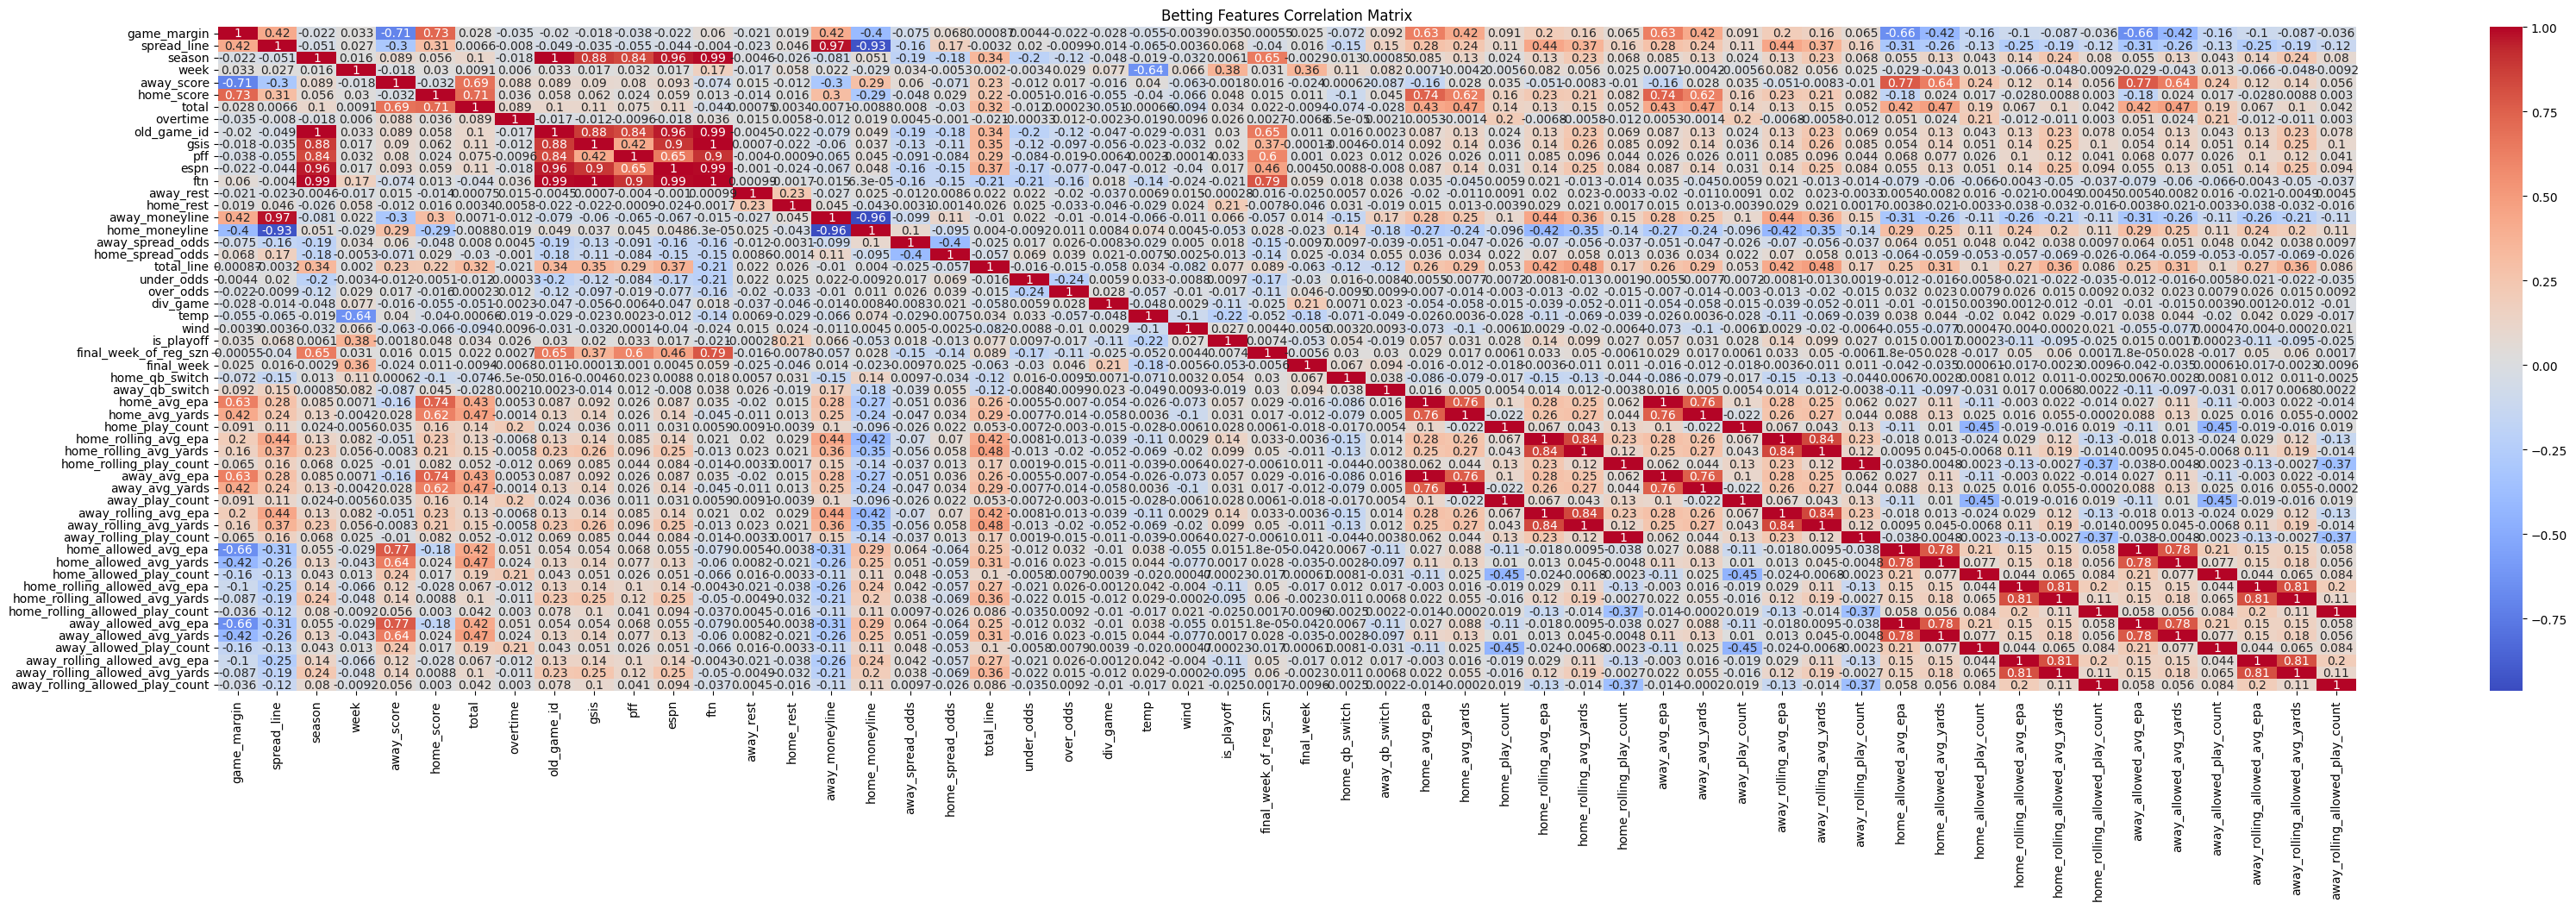

In [ ]:
#correlation matrix -> core question: do any of the features in this dataset lead to high margin of victory for home team? or for away team? This is a pointless question as who wins the game would be due to many other factors.
#so would not take much away from this...nonetheless this is good to show for seeing what features might have collinearity.
#This also shows how regression may not be the best suited modeling technique for our project.

#although the recent team performance metrics are going to be correlated with winning or losing so that makes sense

corr_df = match_df.corr(numeric_only=True)
plt.figure(figsize=(40, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Betting Features Correlation Matrix')
plt.show()

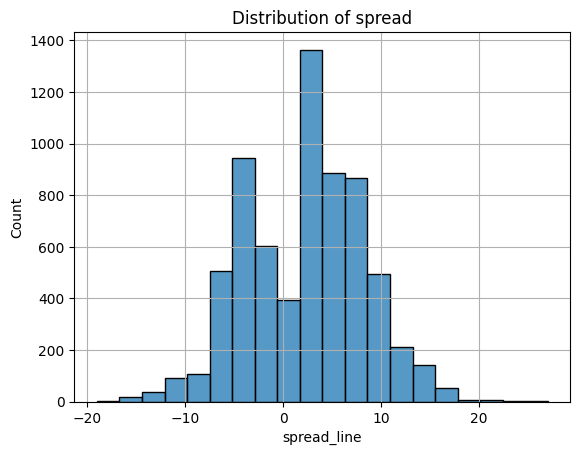

<Figure size 1500x1000 with 0 Axes>

In [ ]:
#distribution of target variable. most spreads tend to be within 10 points of zero
sns.histplot(match_df['spread_line'], bins=20)
plt.grid(True)
plt.title('Distribution of spread')
plt.figure(figsize=(15, 10))
plt.show()

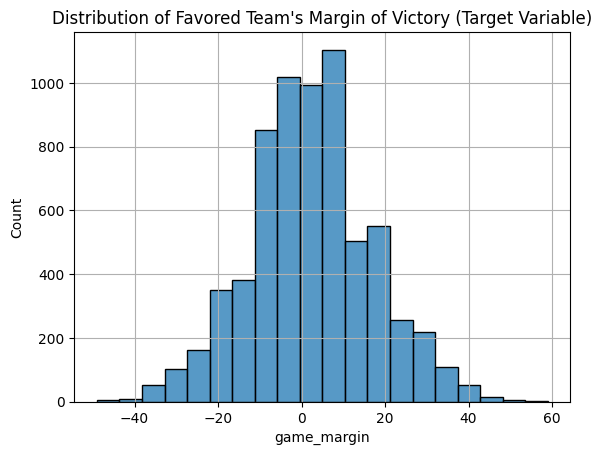

<Figure size 1500x1000 with 0 Axes>

In [ ]:
#distribution of game_margin. most margins of victory are between 20 points of zero. As you can see margin of victory has a larger range compared to spread line
sns.histplot(match_df['game_margin'], bins=20)
plt.grid(True)
plt.title("Distribution of Favored Team's Margin of Victory (Target Variable)")
plt.figure(figsize=(15, 10))
plt.show()

In [ ]:
match_df.head()

,game_id,game_margin,spread_line,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,is_playoff,final_week_of_reg_szn,final_week,home_qb_switch,away_qb_switch,home_avg_epa,home_avg_yards,home_play_count,home_rolling_avg_epa,home_rolling_avg_yards,home_rolling_play_count,away_avg_epa,away_avg_yards,away_play_count,away_rolling_avg_epa,away_rolling_avg_yards,away_rolling_play_count,home_allowed_avg_epa,home_allowed_avg_yards,home_allowed_play_count,home_rolling_allowed_avg_epa,home_rolling_allowed_avg_yards,home_rolling_allowed_play_count,away_allowed_avg_epa,away_allowed_avg_yards,away_allowed_play_count,away_rolling_allowed_avg_epa,away_rolling_allowed_avg_yards,away_rolling_allowed_play_count
0,2000_01_SF_ATL,8.0,6.5,2000,REG,1,2000-09-03,Sunday,13:00,SF,28.0,ATL,36.0,Home,64.0,0.0,2000090310,998.0,NaN,200009030atl,NaN,200903001.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0005755,00-0002876,Jeff Garcia,Chris Chandler,Steve Mariucci,Dan Reeves,Walt Coleman,ATL00,Georgia Dome,False,17,False,False,False,-0.022547,5.698413,63.0,NaN,NaN,NaN,-0.022547,5.698413,63.0,NaN,NaN,NaN,0.059791,5.557377,61.0,NaN,NaN,NaN,0.059791,5.557377,61.0,NaN,NaN,NaN
1,2000_01_JAX_CLE,-20.0,-10.5,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27.0,CLE,7.0,Home,34.0,0.0,2000090306,994.0,NaN,200009030cle,NaN,200903005.0,NaN,7,7,NaN,NaN,NaN,NaN,38.5,NaN,NaN,1,outdoors,grass,78.0,6.0,00-0002110,00-0003535,Mark Brunell,Tim Couch,Tom Coughlin,Chris Palmer,Bernie Kukar,CLE00,Cleveland Browns Stadium,False,17,False,False,False,-0.094077,5.659091,44.0,NaN,NaN,NaN,-0.094077,5.659091,44.0,NaN,NaN,NaN,0.249724,5.102564,78.0,NaN,NaN,NaN,0.249724,5.102564,78.0,NaN,NaN,NaN
2,2000_01_IND_KC,-13.0,-3.5,2000,REG,1,2000-09-03,Sunday,13:00,IND,27.0,KC,14.0,Home,41.0,0.0,2000090305,993.0,NaN,200009030kan,NaN,200903012.0,NaN,7,7,NaN,NaN,NaN,NaN,44.0,NaN,NaN,0,outdoors,grass,90.0,5.0,00-0010346,00-0006300,Peyton Manning,Elvis Grbac,Jim Mora,Gunther Cunningham,Larry Nemmers,KAN00,Arrowhead Stadium,False,17,False,False,False,-0.176144,4.516129,62.0,NaN,NaN,NaN,-0.176144,4.516129,62.0,NaN,NaN,NaN,0.051312,6.079365,63.0,NaN,NaN,NaN,0.051312,6.079365,63.0,NaN,NaN,NaN
3,2000_01_CHI_MIN,3.0,4.5,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27.0,MIN,30.0,Home,57.0,0.0,2000090303,991.0,NaN,200009030min,NaN,200903016.0,NaN,7,7,NaN,NaN,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H. Humphrey Metrodome,False,17,False,False,False,0.212553,6.925926,54.0,NaN,NaN,NaN,0.212553,6.925926,54.0,NaN,NaN,NaN,0.207431,6.250000,68.0,NaN,NaN,NaN,0.207431,6.250000,68.0,NaN,NaN,NaN
4,2000_01_TB_NE,-5.0,-3.0,2000,REG,1,2000-09-03,Sunday,13:00,TB,21.0,NE,16.0,Home,37.0,0.0,2000090312,1000.0,NaN,200009030nwe,NaN,200903017.0,NaN,7,7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0,outdoors,grass,71.0,5.0,00-0009266,00-0001361,Shaun King,Drew Bledsoe,Tony Dungy,Bill Belichick,Jeff Triplette,BOS99,Foxboro Stadium,False,17,False,False,False,-0.210342,4.149254,67.0,NaN,NaN,NaN,-0.210342,4.149254,67.0,NaN,NaN,NaN,0.083789,3.852459,61.0,NaN,NaN,NaN,0.083789,3.852459,61.0,NaN,NaN,NaN


In [ ]:
#drop columns that we are not using as features in the initial dataset, only take data after week 3 because we don't have rolling data before then that is very accurate

features_df = match_df[match_df['week'] >= 3][['game_margin', 'away_rest', 'home_rest', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'is_playoff', 'final_week',
                        'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa',
                        'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_allowed_avg_epa', 'away_allowed_avg_yards', 'away_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count']]

print(features_df.shape)

#drop nan values for any feature
features_df = features_df.dropna()

print(features_df.shape)
features_df

(5939, 34)
(3831, 34)


,game_margin,away_rest,home_rest,total_line,div_game,roof,surface,temp,wind,home_qb_name,away_qb_name,away_coach,home_coach,referee,stadium_id,is_playoff,final_week,home_qb_switch,away_qb_switch,home_rolling_avg_epa,home_rolling_avg_yards,home_rolling_play_count,away_rolling_avg_epa,away_rolling_avg_yards,away_rolling_play_count,home_rolling_allowed_avg_epa,home_rolling_allowed_avg_yards,home_rolling_allowed_play_count,away_allowed_avg_epa,away_allowed_avg_yards,away_allowed_play_count,away_rolling_allowed_avg_epa,away_rolling_allowed_avg_yards,away_rolling_allowed_play_count
30,-5.0,7,7,48.5,1,outdoors,grass,63.0,3.0,Steve Beuerlein,Chris Chandler,Dan Reeves,George Seifert,Larry Nemmers,CAR00,False,False,False,False,0.133196,5.671569,59.5,0.133196,5.671569,59.5,0.041092,6.131148,63.5,-0.205329,4.714286,56.0,0.041092,6.131148,63.5
31,3.0,14,7,35.5,1,outdoors,grass,67.0,12.0,Tim Couch,Kent Graham,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,False,False,False,False,-0.002257,5.631133,53.5,-0.002257,5.631133,53.5,0.086212,4.852753,73.0,0.022379,5.250000,64.0,0.086212,4.852753,73.0
33,3.0,7,7,42.5,0,outdoors,grass,67.0,9.0,Brett Favre,Donovan McNabb,Andy Reid,Mike Sherman,Tony Corrente,GNB00,False,False,False,False,-0.107729,4.532913,53.5,-0.107729,4.532913,53.5,0.040271,4.748545,69.5,-0.243234,2.807018,57.0,0.040271,4.748545,69.5
34,13.0,7,7,41.0,1,outdoors,grass,71.0,5.0,Mark Brunell,Akili Smith,Bruce Coslet,Tom Coughlin,Ed Hochuli,JAX00,False,False,False,False,0.130360,5.395877,76.0,0.130360,5.395877,76.0,0.000774,5.559054,52.5,-0.304806,3.283582,67.0,0.000774,5.559054,52.5
36,13.0,7,6,38.5,1,outdoors,grass,68.0,12.0,Vinny Testaverde,Rob Johnson,Wade Phillips,Al Groh,Ron Winter,NYC00,False,False,False,False,0.058991,5.171622,64.5,0.058991,5.171622,64.5,-0.094936,3.833688,67.0,0.070326,5.949152,59.0,-0.094936,3.833688,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6440,24.0,7,14,44.0,0,outdoors,grass,27.0,16.0,Lamar Jackson,C.J. Stroud,DeMeco Ryans,John Harbaugh,John Hussey,BAL00,True,False,True,False,0.115524,6.194692,62.2,0.115524,6.194692,62.2,-0.114329,5.549818,66.0,-0.221471,4.652174,46.0,-0.114329,5.549818,66.0
6441,3.0,6,13,50.5,0,outdoors,grass,59.0,8.0,Brock Purdy,Jordan Love,Matt LaFleur,Kyle Shanahan,Alex Kemp,SFO01,True,False,True,False,0.169165,7.187590,58.8,0.169165,7.187590,58.8,-0.027652,5.349788,59.2,-0.032437,5.370968,62.0,-0.027652,5.349788,59.2
6443,-3.0,8,6,45.5,0,outdoors,a_turf,25.0,11.0,Josh Allen,Patrick Mahomes,Andy Reid,Sean McDermott,Shawn Hochuli,BUF00,True,False,False,False,0.091564,5.696178,64.0,0.091564,5.696178,64.0,-0.115610,4.840590,56.8,0.244912,8.534883,43.0,-0.115610,4.840590,56.8
6444,-7.0,7,8,44.0,0,outdoors,grass,47.0,7.0,Lamar Jackson,Patrick Mahomes,Andy Reid,John Harbaugh,Shawn Smith,BAL00,True,False,False,False,0.125880,5.972198,61.4,0.125880,5.972198,61.4,-0.179157,5.354225,60.6,0.027584,4.600000,70.0,-0.179157,5.354225,60.6
